# Brainstorm Exam
### Using the Odense Cohorte Data of Language Acquisition in Danish Children

- **timeseries** ???
- seeing from how early on we can forecast childrens language levels - so subsetting the data, and let the last part of the data be the true values we compare to??
- just providing it all data, to see if we can forecast the next step but unsure how its done 
    - either in classical ways: `ARIMA` or `Exponential Smoothing`
    - could be cool in a *LLM* kind of manner, using `iTransformer` or `PatchTST`

<br>

- **machine learning**
- classical ml task of classifying amount of learned language????
    - could be `Forrest/Tree models` or `cluster` based
    - or `regression style` ML

### Data
[Dropbox Dataoverview Link](https://www.dropbox.com/sh/py3npjjxhhdtte6/AACPpAOs8pvrDY6Ug8a90H4da?dl=0)

**Y, outcome:** 
- CDI data of acquired language = CDI_forstaar
- could again be seperated into quantiative/qualitative subgroups

**X, predictors:** 
- Q1-Q4 - maybe choose if it should be home literacy, socioeconomic etc. or maybe all??? maybe a bit of feature engineering is necessary here ... 


# Practising Time Series w. Transporters

Huge shout out to this guy: 
- [Github](https://github.com/jeffheaton/app_deep_learning/blob/main/t81_558_class_10_3_transformer_timeseries.ipynb)

- [Youtube](https://www.youtube.com/watch?v=NGzQpphf_Vc&ab_channel=JeffHeaton)


This example would probably require that we transform the word data into a quantitative count measure at each point in time

In [1]:
import numpy as np
import pandas as pd 
import torch
from torch import nn 

In [12]:
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from torch.optim.lr_scheduler import ReduceLROnPlateau 
import matplotlib.pyplot as plt

In [3]:
### loading in data example of sun bathing spots: 
names = ['year', 'month', 'day', 'dec_year', 'sn_value',
         'sn_error', 'obs_num', 'unused1']
df = pd.read_csv(
    "https://data.heatonresearch.com/data/t81-558/SN_d_tot_V2.0.csv",
    sep=';', header=None, names=names,
    na_values=['-1'], index_col=False)

In [4]:
##### DATA PREPROCESSING 
# This identifies the starting index for slicing the dataframe to exclude all rows up to this index.
start_id = max(df[df['obs_num'] == 0].index.tolist()) + 1
# Creates a new dataframe 'df' by slicing the original dataframe from 'start_id' to the end. The 'copy()' ensures that we get a new dataframe rather than a view of the original dataframe.
df = df[start_id:].copy()
# Changes the data type of the 'sn_value' column in the dataframe 'df' to floating point numbers (floats).
df['sn_value'] = df['sn_value'].astype(float)
df_train = df[df['year'] < 2000] ## Splitting so all data prior year 2000 is training (from 1848)
df_test = df[df['year'] >= 2000]

# Converts the 'sn_value' column in 'df_test' into a numpy array and reshapes it to a two-dimensional array with a single column.
spots_train = df_train['sn_value'].to_numpy().reshape(-1, 1)
spots_test = df_test['sn_value'].to_numpy().reshape(-1, 1)


# Creates an instance of 'StandardScaler', which will be used to standardize (mean = 0, variance = 1) the 'sn_value' data.
scaler = StandardScaler()
spots_train = scaler.fit_transform(spots_train).flatten().tolist() # applying scalar
spots_test = scaler.transform(spots_test).flatten().tolist()


### Sequence
here we define a sequence window of 10 years, which is 'slided' across the data and we look at the ten values for each window and so on and so forth. For each window, we try to predict the 11th timepoint. 

In [5]:
# Sequence Data Preparation
SEQUENCE_SIZE = 10


#### creating function to doing this sequence splitting 
def to_sequences(seq_size, obs):
    x = []
    y = []
    for i in range(len(obs) - seq_size):
        window = obs[i:(i + seq_size)]
        after_window = obs[i + seq_size]
        x.append(window) # the window of 10 observations 
        y.append(after_window) # so this is the 11th observation we want to predict 
    return torch.tensor(x, dtype=torch.float32).view(-1, seq_size, 1), torch.tensor(y, dtype=torch.float32).view(-1, 1)

x_train, y_train = to_sequences(SEQUENCE_SIZE, spots_train)
x_test, y_test = to_sequences(SEQUENCE_SIZE, spots_test)

# Setup data loaders for batch
train_dataset = TensorDataset(x_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

test_dataset = TensorDataset(x_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

### Positional Encoding 
Apparently, when doing timeseries w transformers, we need for the model to know where the observations is in the time window - this cannot be done by simply giving a time stamp integers due to scaling problems, so instead we must make a positional encoding, that the model can use to identify the position of the observation in time.
This is stems from the architecture of the model: since transformers process sequentially by a encoder and decoder structure, this must be done :)

we are encoding the time and the time +1 with a sinus/cosinus encoding to see how they intercept - this allow for a timeseries way of handling the data apparently ==>  these are being added to the inputs as they pass through the model, to provide positional information to that input


In [6]:
# Positional Encoding for Transformer
class PositionalEncoding(nn.Module): ### it is a pytorch module 
    def __init__(self, d_model, dropout=0.1, max_len=5000): 
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term) # these are being added to the inputs as they pass through the model
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

### The Transformer Model 
we make use of the positional encoding before actually letting the transformer encoder see the input. 

**input_dim**: The dimension of the input data, in this case we use only one input, the number of sunspots. *in the exam version this might be more dimensions if we wanna use different versions of CDI*

**d_model**: The number of features in the transformer model's internal representations (also the size of embeddings). This controls how much a model can remember and process.

**nhead**: The number of attention heads in the multi-head self-attention mechanism.

**num_layers**: The number of transformer encoder layers. dropout: The dropout probability.

In [7]:
# Model definition using Transformer
class TransformerModel(nn.Module):
    def __init__(self, input_dim=1, d_model=64, nhead=4, num_layers=2, dropout=0.2): # these should be thoroughly considered,as they affect the model
        super(TransformerModel, self).__init__()

        self.encoder = nn.Linear(input_dim, d_model)
        self.pos_encoder = PositionalEncoding(d_model, dropout) # first we use the pos encoder on the input
        encoder_layers = nn.TransformerEncoderLayer(d_model, nhead) # then the actual transformer encoder, which is doing the internal representation of the input
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers)
        self.decoder = nn.Linear(d_model, 1) # now decoding to an output == the prediction of the next value 

    def forward(self, x):
        x = self.encoder(x)
        x = self.pos_encoder(x)
        x = self.transformer_encoder(x)
        x = self.decoder(x[:, -1, :])
        return x


In [8]:
### initalizing the model: 
# Make use of a GPU or MPS (Apple) if one is available.  
import torch
has_mps = torch.backends.mps.is_built()
device = "mps" if has_mps else "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")


### fitting the model
model = TransformerModel().to(device)

Using device: cpu


/work/LauraWulffPaaby#7567/DatSci_24_forked/DataSci-AU-24/venv_dat_sci24/lib/python3.10/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


# Training the model: 

In [9]:
# Train the model
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=3, verbose=True)

epochs = 1000
early_stop_count = 0
min_val_loss = float('inf')

for epoch in range(epochs):
    model.train()
    for batch in train_loader:
        x_batch, y_batch = batch
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        outputs = model(x_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

    # Validation
    model.eval()
    val_losses = []
    with torch.no_grad():
        for batch in test_loader:
            x_batch, y_batch = batch
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            outputs = model(x_batch)
            loss = criterion(outputs, y_batch)
            val_losses.append(loss.item())

    val_loss = np.mean(val_losses)
    scheduler.step(val_loss)

    if val_loss < min_val_loss:
        min_val_loss = val_loss
        early_stop_count = 0
    else:
        early_stop_count += 1

    if early_stop_count >= 5:
        print("Early stopping!")
        break
    print(f"Epoch {epoch + 1}/{epochs}, Validation Loss: {val_loss:.4f}")

/work/LauraWulffPaaby#7567/DatSci_24_forked/DataSci-AU-24/venv_dat_sci24/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1/1000, Validation Loss: 0.0501
Epoch 2/1000, Validation Loss: 0.0385
Epoch 3/1000, Validation Loss: 0.0397
Epoch 4/1000, Validation Loss: 0.0369
Epoch 5/1000, Validation Loss: 0.0415
Epoch 6/1000, Validation Loss: 0.0444
Epoch 7/1000, Validation Loss: 0.0376
Epoch 8/1000, Validation Loss: 0.0457
Epoch 9/1000, Validation Loss: 0.0352
Epoch 10/1000, Validation Loss: 0.0345
Epoch 11/1000, Validation Loss: 0.0345
Epoch 12/1000, Validation Loss: 0.0388
Epoch 13/1000, Validation Loss: 0.0357
Epoch 14/1000, Validation Loss: 0.0352
Epoch 15/1000, Validation Loss: 0.0369
Early stopping!


In [10]:
# Evaluation
model.eval()
predictions = []
with torch.no_grad():
    for batch in test_loader:
        x_batch, y_batch = batch
        x_batch = x_batch.to(device)
        outputs = model(x_batch)
        predictions.extend(outputs.squeeze().tolist())

rmse = np.sqrt(np.mean((scaler.inverse_transform(np.array(predictions).reshape(-1, 1)) - scaler.inverse_transform(y_test.numpy().reshape(-1, 1)))**2))
print(f"Score (RMSE): {rmse:.4f}")

Score (RMSE): 14.7772


### Visualization
Predicted vs. true ys (which is here sunspots)

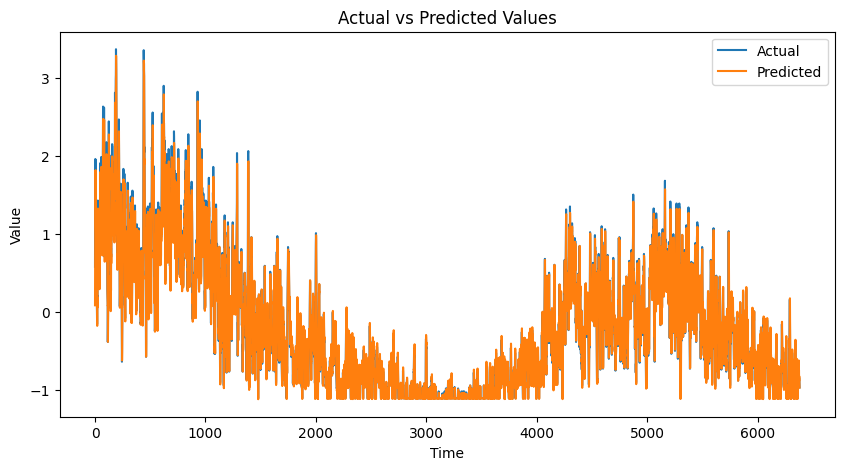

In [14]:
# Predict the test set
# Put the model in evaluation mode. This is necessary because some layers like dropout or batchnorm
# behave differently during training vs during testing.
model.eval()

# Lists to store the predicted and actual values.
test_predictions = []
test_actuals = []

# torch.no_grad() tells PyTorch that we do not need to compute gradients during the forward pass.
# This reduces memory consumption for computations, since gradients aren’t needed.
with torch.no_grad():
    for batch in test_loader:  # Loop over each batch from the test DataLoader.
        x_batch, y_batch = batch  # Unpack the batch to get the input data and labels.
        x_batch = x_batch.to(device)  # Move the input data to the device (CPU/GPU).
        
        # Get model predictions for the current batch, move the predictions back to CPU,
        # convert them to numpy array and extend the test_predictions list with these values.
        test_predictions.extend(model(x_batch).cpu().numpy())
        
        # Extend the test_actuals list with the actual values (ground truth).
        test_actuals.extend(y_batch.numpy())

# Plotting the actual vs predictions
plt.figure(figsize=(10, 5))
plt.plot(test_actuals, label='Actual')
plt.plot(test_predictions, label='Predicted')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.title('Actual vs Predicted Values')
plt.show()


The time x is kind of weird, becuase we predict the 11th observation after each window-sequence of 10 timestamps, rather than the one after year 2000??? i am looking into how to fix this :DDD 